Clustering and PCA

In [68]:
library(stats)
library(dplyr)
library(ggplot2)
library(ggfortify)
library(tidyverse)
library(factoextra)
library(knitr)
library(arules)
library(arulesViz)
library(igraph)
options(warn = -1)

In [4]:
df <- read.csv("data/wine.csv")


In [ ]:
sum(is.na(df))

In [7]:
df_normalized <- df %>%
  mutate(across(where(is.numeric), scale)) %>%
  mutate(color = df$color, quality = df$quality)

In [8]:
# Ensure 'color' and 'quality' are factors if they are being used as categorical aesthetics
df_normalized <- df_normalized %>%
  mutate(color = as.factor(color),
         quality = as.factor(quality))


In this part, firstly I have tried pca to see if it could distinguish the color and quality. The result is displayed below. We could see that the distribution of color is clear but the quality is a mass. 

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     1.7407 1.5792 1.2475 0.98517 0.84845 0.77930 0.72330
Proportion of Variance 0.2754 0.2267 0.1415 0.08823 0.06544 0.05521 0.04756
Cumulative Proportion  0.2754 0.5021 0.6436 0.73187 0.79732 0.85253 0.90009
                           PC8     PC9   PC10    PC11
Standard deviation     0.70817 0.58054 0.4772 0.18119
Proportion of Variance 0.04559 0.03064 0.0207 0.00298
Cumulative Proportion  0.94568 0.97632 0.9970 1.00000

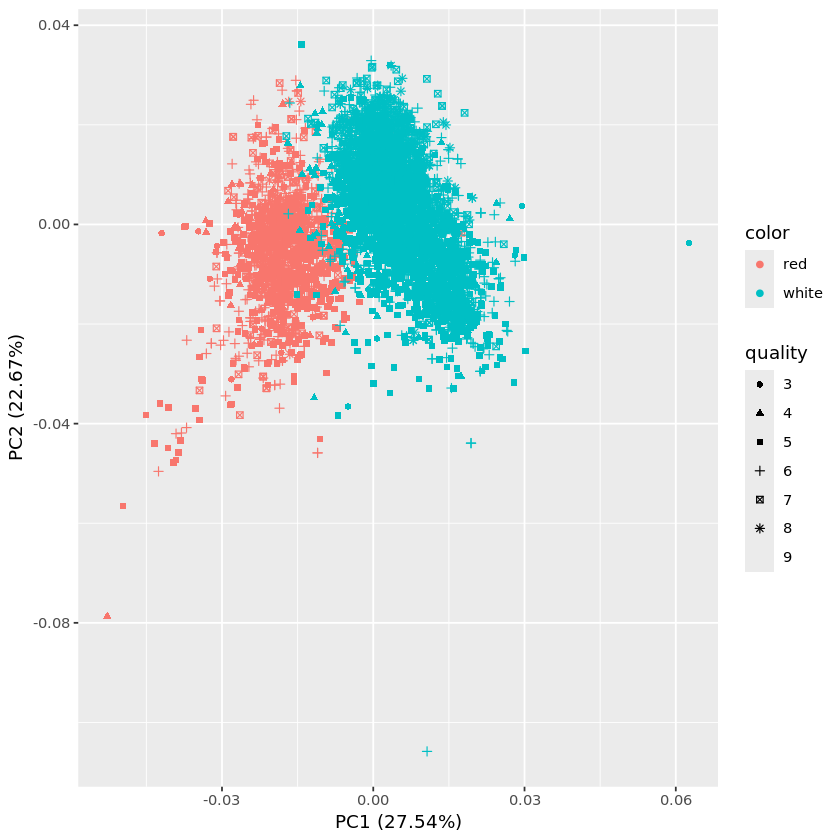

In [9]:
pca_result <- prcomp(df_normalized[,1:11], center = TRUE, scale. = TRUE)
autoplot(pca_result, data = df_normalized, colour = 'color', shape = 'quality')
summary(pca_result)


In [10]:
# Prepare a data frame for plotting
wine_pca_df <- data.frame(pca_result$x)
wine_pca_df$quality <- factor(df$quality)

Thus I try to only plot the distribution of quality. The plot is followed. From this plot we could see that pca may could distinguish the quality level but the graph could be a mass.

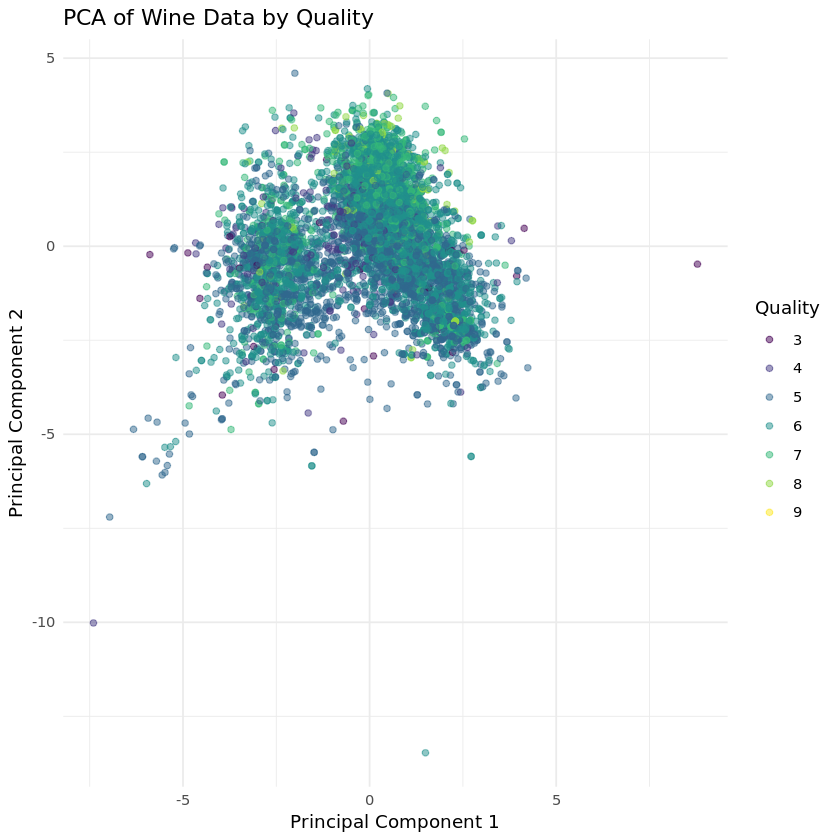

In [11]:
# Plot the first two principal components
ggplot(wine_pca_df, aes(x = PC1, y = PC2, color = quality)) +
  geom_point(alpha = 0.5) +
  scale_color_viridis_d() +  # Using a discrete color scale
  labs(title = "PCA of Wine Data by Quality",
       x = "Principal Component 1",
       y = "Principal Component 2",
       color = "Quality") +
  theme_minimal()

In [12]:
wine_pca <- data.frame(pca_result$x[, 1:2])  # using the first two principal components

Optimal number of clusters seems useless. 

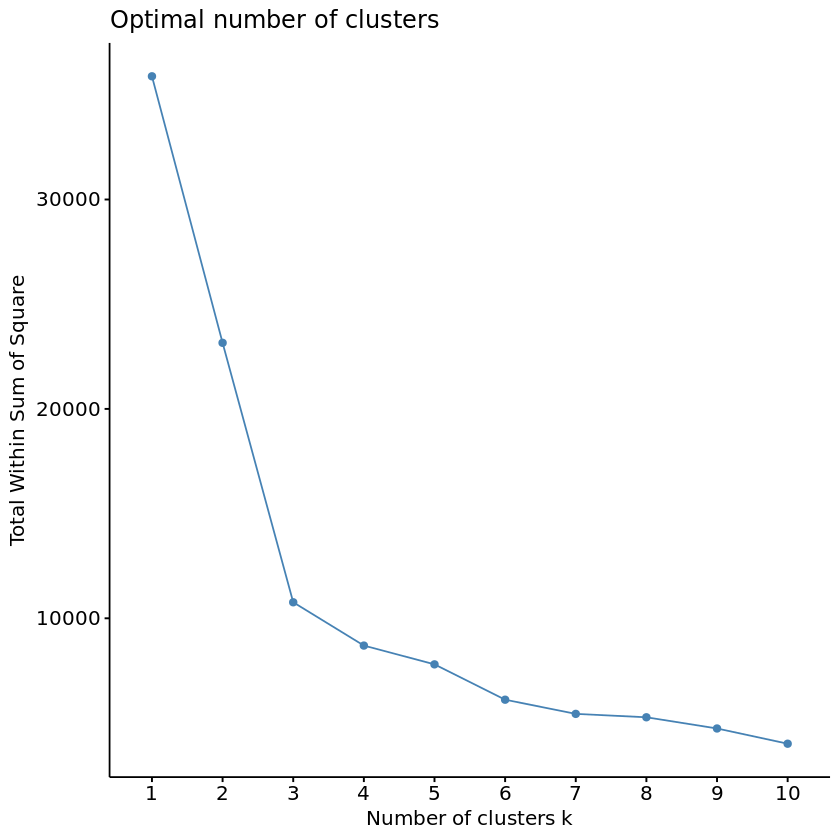

In [13]:
set.seed(123)  # for reproducibility
fviz_nbclust(pca_result$x[,1:2], kmeans, method = "wss")

In [14]:
kmeans_result <- kmeans(pca_result$x[,1:2], centers = 7)
df_normalized$cluster <- as.factor(kmeans_result$cluster)

In [ ]:
# Determine the appropriate number of clusters
set.seed(234)  # for reproducibility
fviz_nbclust(wine_pca, kmeans, method = "wss")  # Elbow method to suggest number of clusters

# Apply K-means clustering
k <- 7  # let's assume the elbow plot suggests 4 clusters
kmeans_result <- kmeans(wine_pca, centers = k, nstart = 25)

# Add cluster results to the data
df$cluster <- kmeans_result$cluster

Then I tried kmeans as comparison. I set the centers to 7, aiming to detect the 7 quality levels. The result is followed. We could see that the kmeans is not capable to distinguish the quality level.



Table: Summary of Wine Quality by Cluster

| cluster| Average_Quality| Min_Quality| Max_Quality| Count|
|-------:|---------------:|-----------:|-----------:|-----:|
|       3|        6.325269|           3|           9|  1116|
|       1|        6.135708|           4|           8|  1179|
|       6|        5.671413|           3|           8|   913|
|       5|        5.654867|           3|           8|   791|
|       2|        5.634826|           3|           9|  1005|
|       7|        5.543478|           3|           8|   598|
|       4|        5.452514|           3|           8|   895|

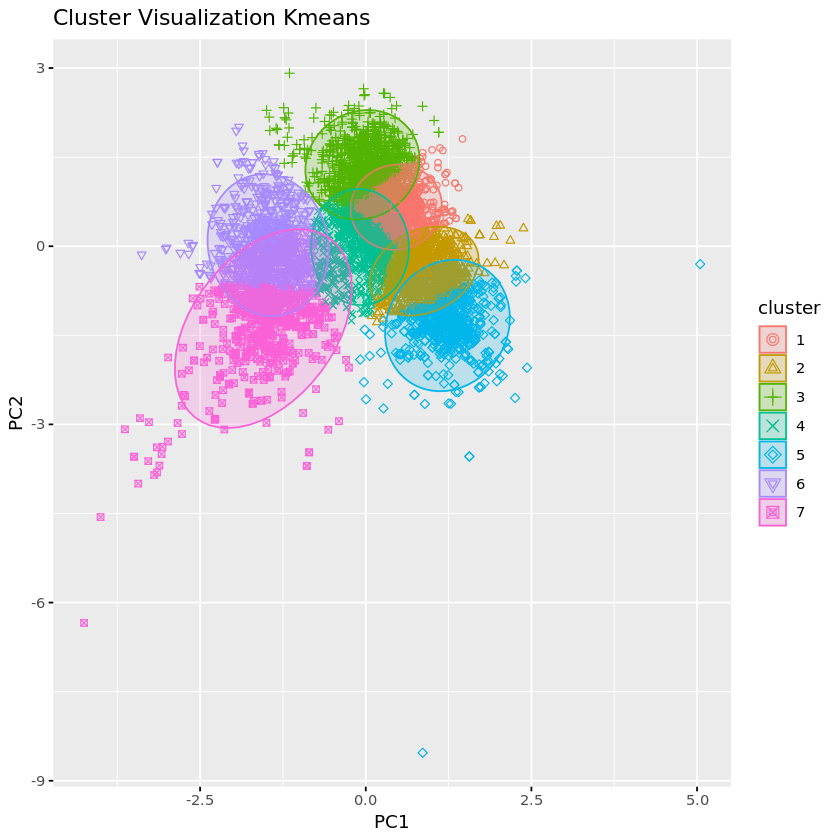

In [16]:
# Visualize clusters with PCA components
fviz_cluster(kmeans_result, data = wine_pca, geom = "point", ellipse.type = "norm", 
             main = "Cluster Visualization Kmeans", xlab = "PC1", ylab = "PC2")

# Analyzing cluster by wine quality and formatting with kable for Markdown
cluster_summary <- df %>%
  group_by(cluster) %>%
  summarise(Average_Quality = mean(quality, na.rm = TRUE),
            Min_Quality = min(quality, na.rm = TRUE),
            Max_Quality = max(quality, na.rm = TRUE),
            Count = n()) %>%
  arrange(desc(Average_Quality))

# Print table using kable
kable(cluster_summary, format = "markdown", caption = "Summary of Wine Quality by Cluster")



But kmeans coud clearly distinguish the color of wine as displayed below setting centers to 2.

In [17]:

# Apply K-means clustering
k <- 2  # let's assume the elbow plot suggests 4 clusters
kmeans_result <- kmeans(wine_pca, centers = k, nstart = 25)

# Add cluster results to the data
df$cluster <- kmeans_result$cluster



Table: Summary of Wine Quality by Cluster

| cluster| Average_Quality| Min_Quality| Max_Quality| Count|
|-------:|---------------:|-----------:|-----------:|-----:|
|       1|        5.891965|           3|           9|  4841|
|       2|        5.603261|           3|           8|  1656|

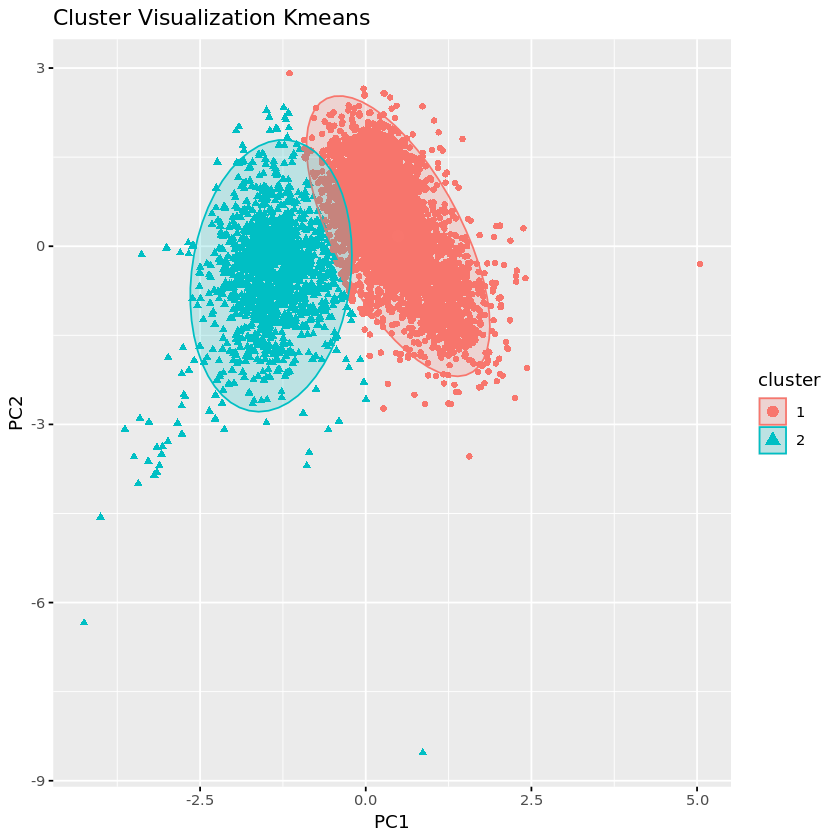

In [18]:
# Visualize clusters with PCA components
fviz_cluster(kmeans_result, data = wine_pca, geom = "point", ellipse.type = "norm", 
             main = "Cluster Visualization Kmeans", xlab = "PC1", ylab = "PC2")

# Analyzing cluster by wine quality and formatting with kable for Markdown
cluster_summary <- df %>%
  group_by(cluster) %>%
  summarise(Average_Quality = mean(quality, na.rm = TRUE),
            Min_Quality = min(quality, na.rm = TRUE),
            Max_Quality = max(quality, na.rm = TRUE),
            Count = n()) %>%
  arrange(desc(Average_Quality))

# Print table using kable
kable(cluster_summary, format = "markdown", caption = "Summary of Wine Quality by Cluster")




Market segmentation

In [19]:
library(tidyverse)   
library(cluster)     
library(factoextra)

In [20]:
data <- read.csv("data/social_marketing.csv")

In [ ]:
sum(is.na(data))

In [23]:
# Scale the data - only the interest categories, assuming they start from the second column
data_scaled <- as.data.frame(scale(data[, 2:ncol(data)]))

In this part, firstly I use pca to finish the market segmentation mission. First I check for the scale dimensions. We could see that the highest percentage of explained variance just beyond 12, which is low.

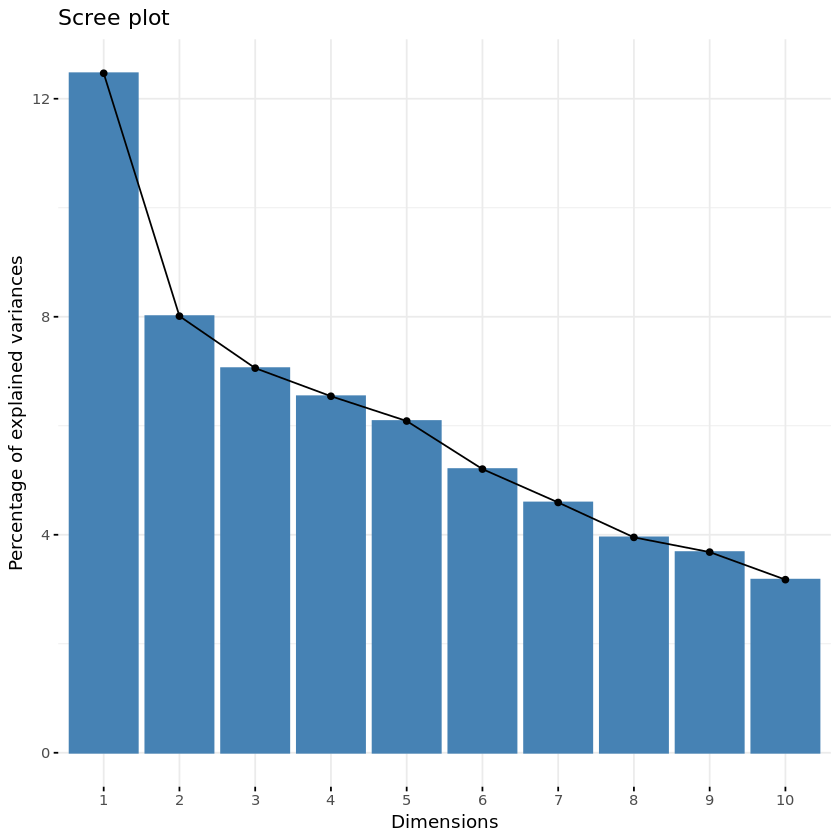

In [24]:
# Perform PCA
pca_results <- prcomp(data_scaled, scale. = TRUE)

# Plot explained variance to determine the number of components to retain
fviz_eig(pca_results)


Then applying kmeans to detect the optimal dimensions. The result is followed. Seems like 5 dimensions could be the optimal number.

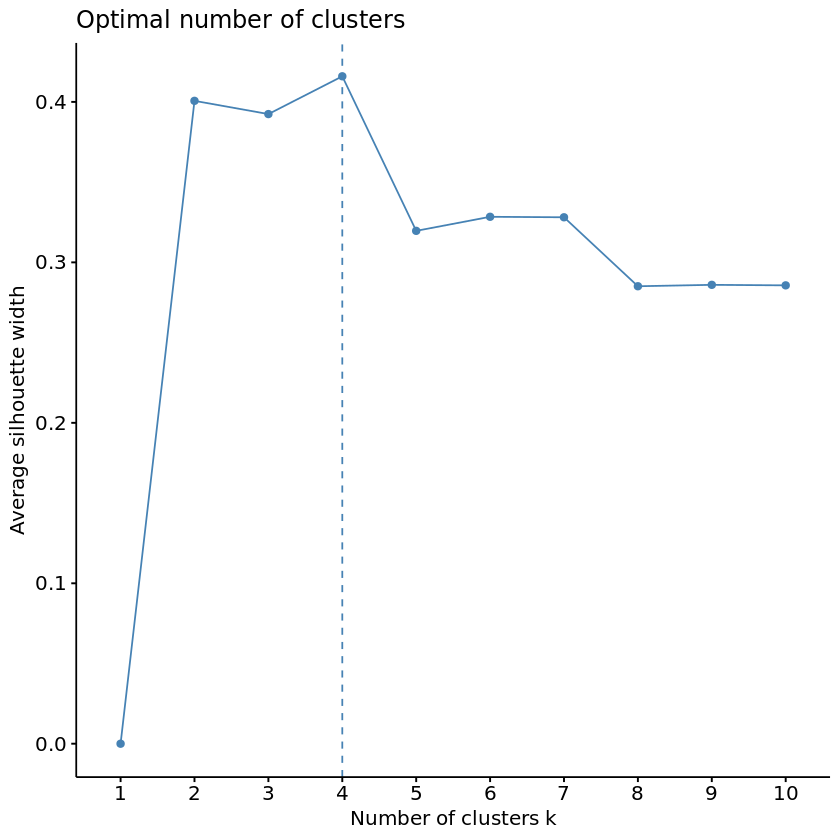

In [26]:
# Assuming we decide to use the first three principal components
data_pca_scores <- data.frame(pca_results$x[, 1:3])

# Determine the optimal number of clusters
fviz_nbclust(data_pca_scores, kmeans, method = "silhouette")

# Perform k-means clustering
set.seed(123)  # for reproducibility
kmeans_results <- kmeans(data_pca_scores, centers = 5, nstart = 25)

# Add cluster assignments back to the original data
data$cluster <- kmeans_results$cluster


Then calculate the distribution of variables in each cluster. The whole table looks complex then I calculate the top 5 variables in each column.

In [53]:
# Assuming 'data' has 'cluster' assigned and interest categories start from the second column
cluster_summary <- aggregate(data[, 2:ncol(data)], by = list(Cluster = data$cluster), mean)
# Add a new column for the favorite interest
cluster_summary$Main_Favorite <- apply(cluster_summary[, -1], 1, function(x) names(x)[which.max(x)])
# Print the enhanced cluster summary using kable for a nicer format
kable(cluster_summary, caption = "Cluster Summary with Main Favorites", align = 'c')



Table: Cluster Summary with Main Favorites

| Cluster | chatter  | current_events |  travel  | photo_sharing | uncategorized |  tv_film  | sports_fandom | politics  |   food   |  family   | home_and_garden |   music   |   news    | online_gaming | shopping  | health_nutrition | college_uni | sports_playing |  cooking  |    eco    | computers | business  | outdoors  |  crafts   | automotive |    art    | religion  |  beauty   | parenting |  dating   |  school   | personal_fitness |  fashion  | small_business |   spam    |   adult   | cluster | Main_Favorite |
|:-------:|:--------:|:--------------:|:--------:|:-------------:|:-------------:|:---------:|:-------------:|:---------:|:--------:|:---------:|:---------------:|:---------:|:---------:|:-------------:|:---------:|:----------------:|:-----------:|:--------------:|:---------:|:---------:|:---------:|:---------:|:---------:|:---------:|:----------:|:---------:|:---------:|:---------:|:---------:|:---------:|:---------:|:----------

In [50]:

# Optionally, use `kable` from knitr for a nicer table format in reports
library(knitr)

# Assuming 'data' has 'cluster' assigned and interest categories start from the second column
cluster_summary <- aggregate(data[, 2:ncol(data)], by = list(Cluster = data$cluster), mean)

# Assuming 'Cluster' is the first and the last column
cluster_summary <- cluster_summary[, -c(1, ncol(cluster_summary))]



In [51]:
# Add a column for the top five favorites
cluster_summary$Top5_Favorites <- apply(cluster_summary[, -1], 1, function(x) {
  # Sorts the interests in decreasing order of mean value and gets the names of the top five
  top5 <- names(sort(x, decreasing = TRUE))[1:5]
  paste(top5, collapse = ", ")
})


Based on this simplified table, I named the 5 clusters from the top to bottom as "looks serious", "looks healthy", "third cluster third", "kind of similar to first", and "similar to second". I think NutrientH20 could make policy to attract both the "looks serious" group and "looks healthy" group for there are two other groups similar to these clusters. 

In [52]:
# Select only the Top5_Favorites for the final display
final_summary <- cluster_summary["Top5_Favorites"]

# Print the final summary table using kable
kable(final_summary, caption = "Top Five Favorites in Each Cluster", align = 'c')



Table: Top Five Favorites in Each Cluster

|                             Top5_Favorites                              |
|:-----------------------------------------------------------------------:|
|            politics, travel, news, computers, photo_sharing             |
|   cooking, health_nutrition, photo_sharing, fashion, personal_fitness   |
|            sports_fandom, religion, food, parenting, school             |
|    photo_sharing, current_events, health_nutrition, travel, politics    |
| health_nutrition, photo_sharing, cooking, personal_fitness, college_uni |

Association rules for grocery purchases

In [54]:
groceries_raw <- readLines("data/groceries.txt")

In [55]:
# Split each line into individual items
groceries_list <- strsplit(groceries_raw, ",")

# Remove any potential white spaces around item names
groceries_list <- lapply(groceries_list, trimws)

# Convert the list to a transaction class
groceries_trans <- as(groceries_list, "transactions")

In this part, firstly I set support_threshold = 0.01
confidence_threshold = 0.1
lift_threshold = 0, just give it a random try. 

In [79]:
# Define thresholds
support_threshold = 0.01
confidence_threshold = 0.1
lift_threshold = 0

# Run the apriori algorithm
grocery_rules = apriori(groceries_trans, 
                        parameter = list(support = support_threshold, 
                                         confidence = confidence_threshold, 
                                         maxlen = 4))

# Filter rules based on lift
interesting_rules = subset(grocery_rules, lift > lift_threshold)

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.1    0.1    1 none FALSE            TRUE       5    0.01      1
 maxlen target  ext
      4  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 98 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[169 item(s), 9835 transaction(s)] done [0.00s].
sorting and recoding items ... [88 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [435 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [ ]:
subset_rules <- subset(grocery_rules, subset=lift > 5)
if(length(subset_rules) == 0) {
  cat("No rules found with the specified criteria.")
} else {
  inspect(subset_rules)
}

This plot contains a lot of information but useless for us to find some interesting insights. 

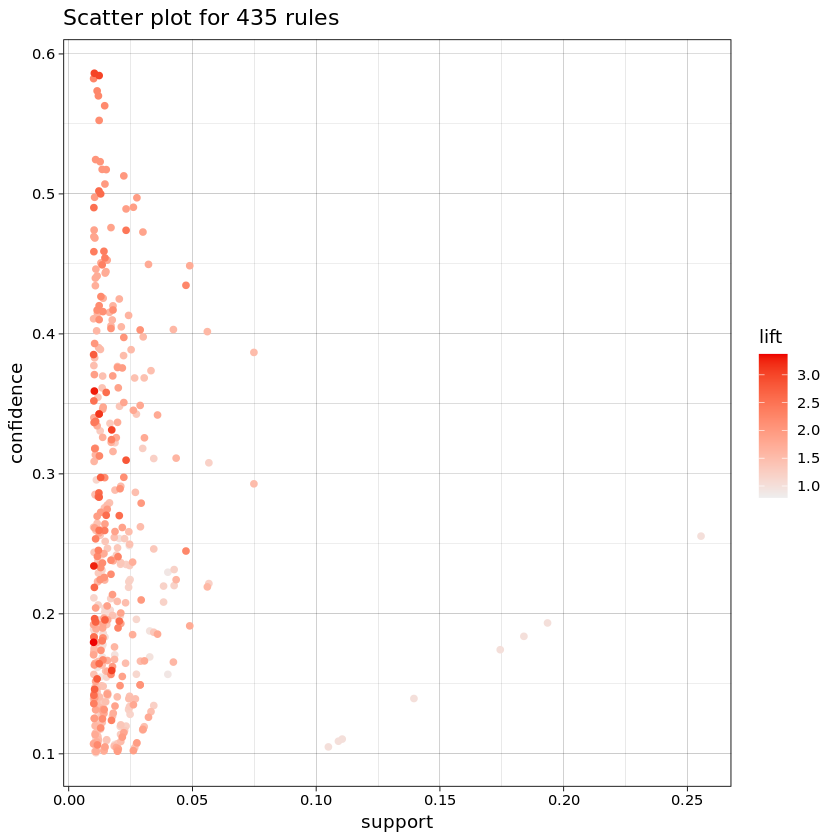

In [83]:
# Plot using scatterplot with support and confidence
plot(interesting_rules, measure = c("support", "confidence"), shading = "lift", jitter = 0)

Complex graph, it's hard to directly gain the relationship from the graph.

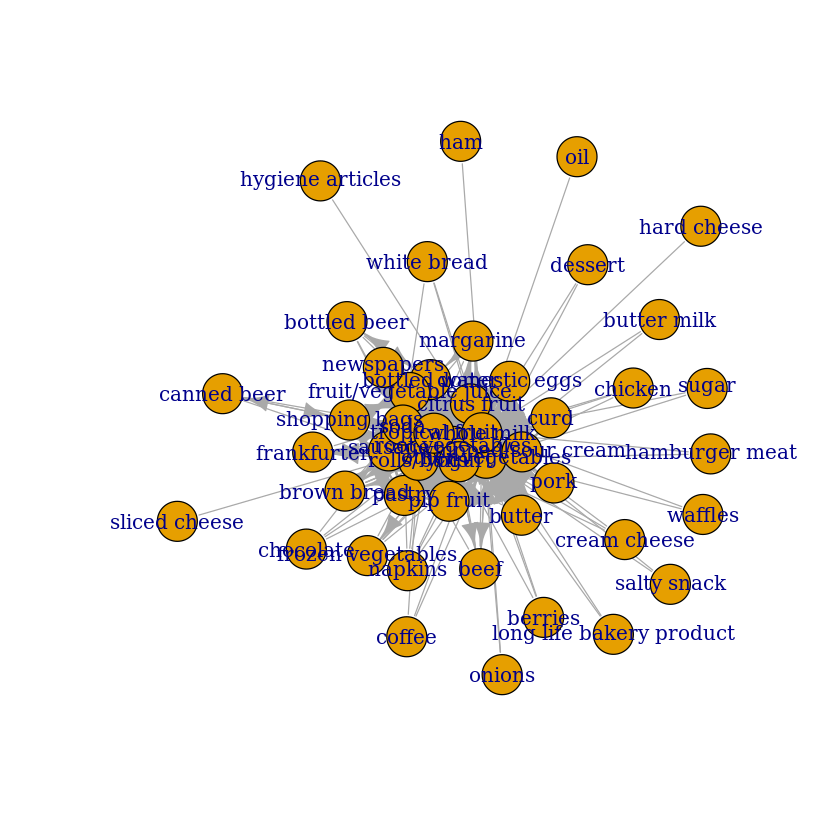

In [84]:
# Graph-based visualization
grocery_graph = associations2igraph(interesting_rules, associationsAsNodes = FALSE)
igraph::plot.igraph(grocery_graph)

Then I choose higher lift_threshold = 2, keep the others constant.

In [61]:
# Define thresholds
support_threshold = 0.01
confidence_threshold = 0.1
lift_threshold = 2

# Run the apriori algorithm
grocery_rules = apriori(groceries_trans, 
                        parameter = list(support = support_threshold, 
                                         confidence = confidence_threshold, 
                                         maxlen = 4))

# Filter rules based on lift
interesting_rules = subset(grocery_rules, lift > lift_threshold)



Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.1    0.1    1 none FALSE            TRUE       5    0.01      1
 maxlen target  ext
      4  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 98 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[169 item(s), 9835 transaction(s)] done [0.00s].
sorting and recoding items ... [88 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [435 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [ ]:
subset_rules <- subset(grocery_rules, subset=lift > 5)
if(length(subset_rules) == 0) {
  cat("No rules found with the specified criteria.")
} else {
  inspect(subset_rules)
}


This time the plot contains less information. Then visualize the result of estimation. 

To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



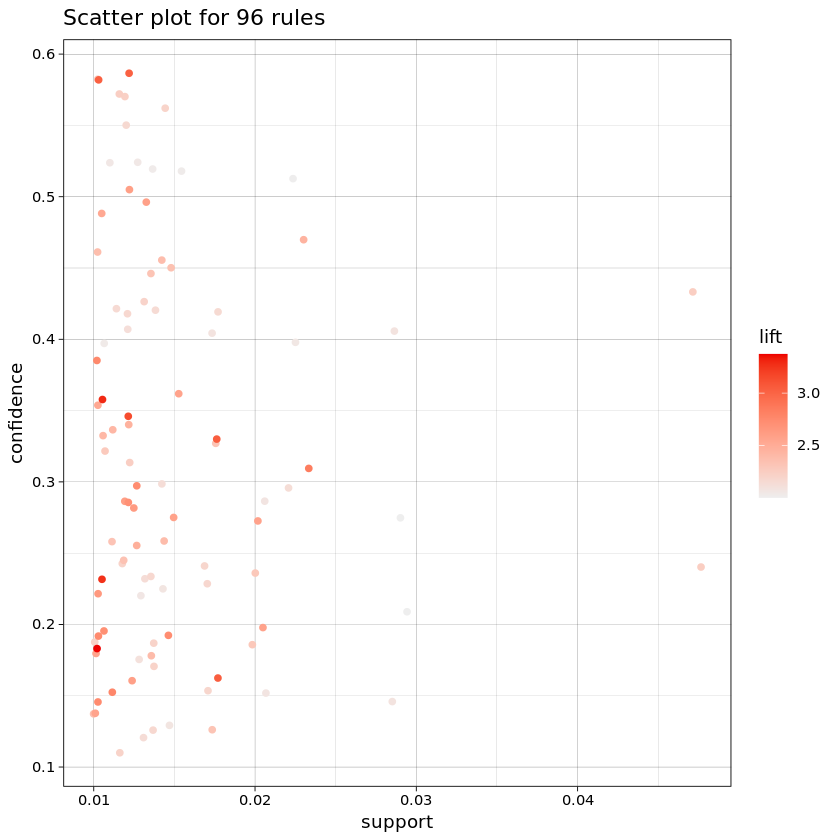

In [63]:
# Plot using scatterplot with support and confidence
plot(interesting_rules, measure = c("support", "confidence"), shading = "lift")

It's better but still not that clear.

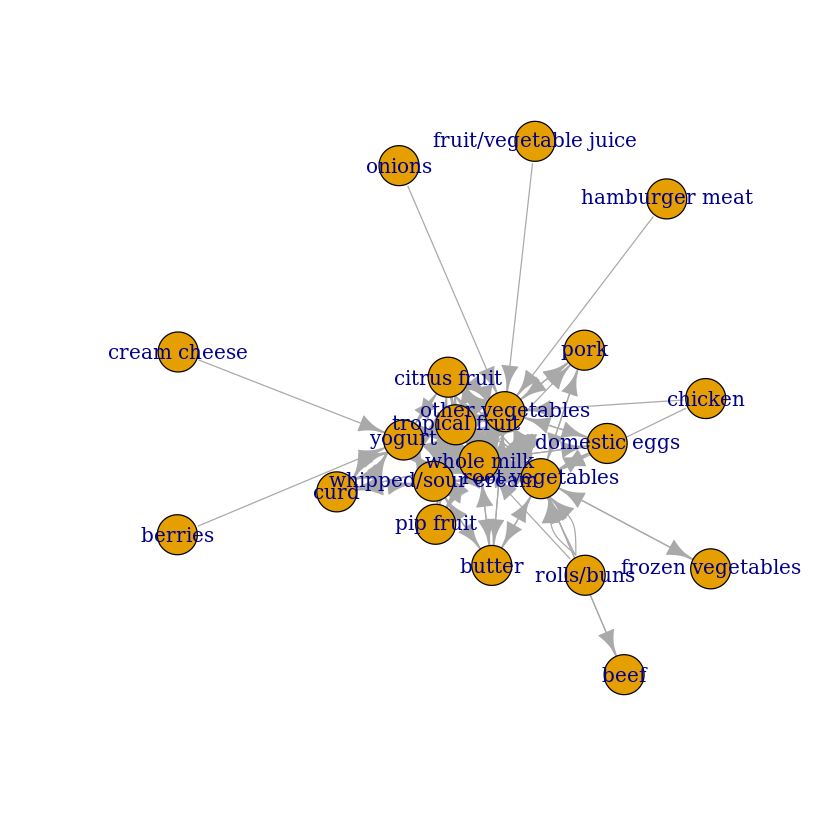

In [64]:
# Graph-based visualization
grocery_graph = associations2igraph(interesting_rules, associationsAsNodes = FALSE)
igraph::plot.igraph(grocery_graph)

In [65]:
# Inspect top rules by lift
inspect(interesting_rules)


     lhs                         rhs                     support confidence   coverage     lift count
[1]  {onions}                 => {other vegetables}   0.01423488  0.4590164 0.03101169 2.372268   140
[2]  {berries}                => {yogurt}             0.01057448  0.3180428 0.03324860 2.279848   104
[3]  {hamburger meat}         => {other vegetables}   0.01382816  0.4159021 0.03324860 2.149447   136
[4]  {cream cheese}           => {yogurt}             0.01240468  0.3128205 0.03965430 2.242412   122
[5]  {chicken}                => {root vegetables}    0.01087951  0.2535545 0.04290798 2.326221   107
[6]  {chicken}                => {other vegetables}   0.01789527  0.4170616 0.04290798 2.155439   176
[7]  {frozen vegetables}      => {root vegetables}    0.01159126  0.2410148 0.04809354 2.211176   114
[8]  {root vegetables}        => {frozen vegetables}  0.01159126  0.1063433 0.10899847 2.211176   114
[9]  {beef}                   => {root vegetables}    0.01738688  0.3313953 0.0524

This time I set lift_threshold = 3 aiming to detect more specific relationships in the shopping baskets.

In [87]:
# Define thresholds
support_threshold = 0.01
confidence_threshold = 0.1
lift_threshold = 3

# Run the apriori algorithm
grocery_rules = apriori(groceries_trans, 
                        parameter = list(support = support_threshold, 
                                         confidence = confidence_threshold, 
                                         maxlen = 4))

# Filter rules based on lift
interesting_rules = subset(grocery_rules, lift > lift_threshold)

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.1    0.1    1 none FALSE            TRUE       5    0.01      1
 maxlen target  ext
      4  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 98 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[169 item(s), 9835 transaction(s)] done [0.00s].
sorting and recoding items ... [88 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [435 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [ ]:
subset_rules <- subset(grocery_rules, subset=lift > 5)
if(length(subset_rules) == 0) {
  cat("No rules found with the specified criteria.")
} else {
  inspect(subset_rules)
}

The plot looks clear now. Visualize them. 

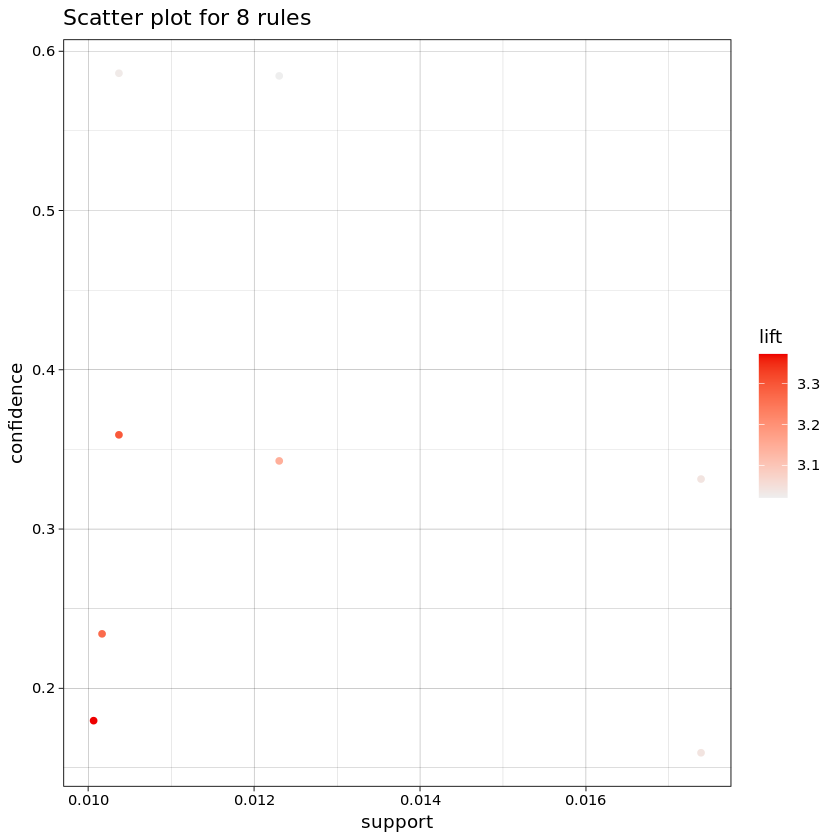

In [89]:
# Plot using scatterplot with support and confidence
plot(interesting_rules, measure = c("support", "confidence"), shading = "lift")

We could gain direct information from the graph now. Check for the table for details.

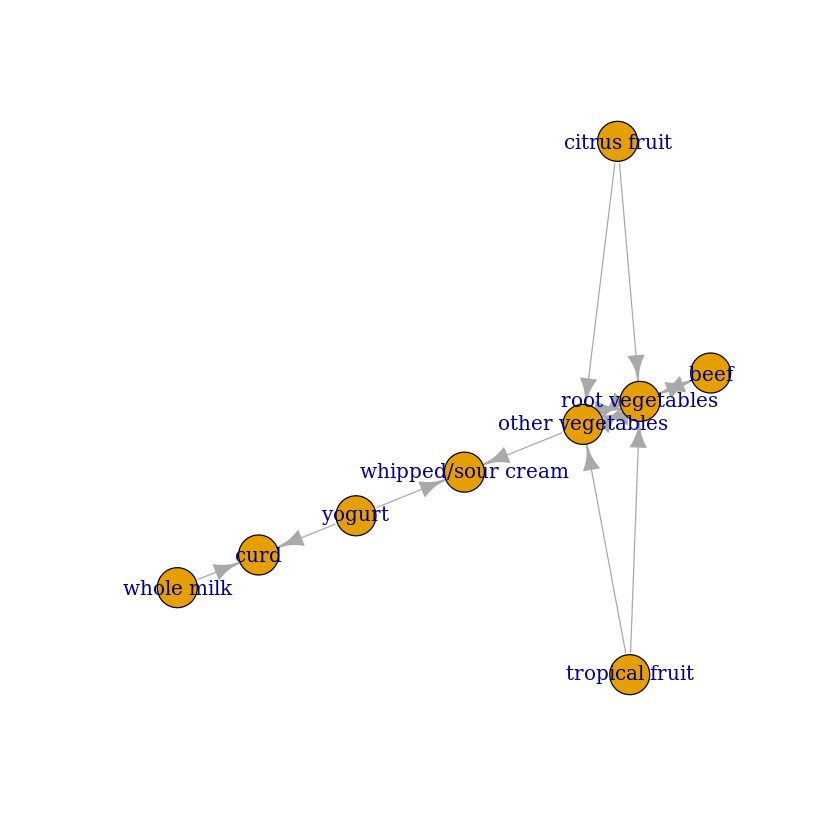

In [90]:
# Graph-based visualization
grocery_graph = associations2igraph(interesting_rules, associationsAsNodes = FALSE)
igraph::plot.igraph(grocery_graph)

In [91]:
# Inspect top rules by lift
inspect(interesting_rules)

    lhs                                   rhs                  support   
[1] {beef}                             => {root vegetables}    0.01738688
[2] {root vegetables}                  => {beef}               0.01738688
[3] {whole milk, yogurt}               => {curd}               0.01006609
[4] {other vegetables, yogurt}         => {whipped/sour cream} 0.01016777
[5] {citrus fruit, root vegetables}    => {other vegetables}   0.01037112
[6] {citrus fruit, other vegetables}   => {root vegetables}    0.01037112
[7] {root vegetables, tropical fruit}  => {other vegetables}   0.01230300
[8] {other vegetables, tropical fruit} => {root vegetables}    0.01230300
    confidence coverage   lift     count
[1] 0.3313953  0.05246568 3.040367 171  
[2] 0.1595149  0.10899847 3.040367 171  
[3] 0.1796733  0.05602440 3.372304  99  
[4] 0.2341920  0.04341637 3.267062 100  
[5] 0.5862069  0.01769192 3.029608 102  
[6] 0.3591549  0.02887646 3.295045 102  
[7] 0.5845411  0.02104728 3.020999 121  
[8] 0.

From the detailed table, we could see that people with beef in barket have higher possibility to buy root vegetables but lower possibility in opposite. I guess that's because if people want to eat beef then they would buy beef firstly then choose root vegetables as side dish. But if people buy root vegetables in advance they may just want to eat some vegetables.  
Also I have found that both people with citrus fruit or tropical fruit would in high possibility to search for root vegetables or other vegetables if they are already with one. For example, with citrus fruit and root vagetables, people have beyond a half possibility to search for other vegetables. And the possibility is almost the same for people with tropical fruit and root vegetables. But if with other vegetables and fruit, the possibility to search for root vegetables is only around 35 percent.  

Image classification with neural networks

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
data_dir = 'data/EuroSAT_RGB'

In [3]:
batch_size = 4

In [4]:
transform = transforms.Compose(
    [transforms.Resize((32, 32)),  # Resize images to 32x32
     transforms.ToTensor(),  # Convert image to PyTorch Tensor data type
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

In [5]:
dataset = ImageFolder(root=data_dir, transform=transform)

In [6]:
train_ratio = 0.8
total_size = len(dataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

In [7]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# Creating data loaders for both training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # Increase filters, adjust kernel size
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Adjust the size according to your feature map dimensions
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, len(dataset.classes))

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)  # Adjust flattening to match the output of the last conv layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
model = EnhancedCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



In [ ]:
num_epochs = 10  # You can adjust this based on your computation time
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # Print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In this part I have built a neural network using an 80/20 train test split. I trained a model with conv1, conv2, conv3 in which Convolutional layers increasing in filter size from 32 to 128. All with a kernel size of 3 and padding of 1 to maintain the spatial dimensions when stride is 1. Also set batchnorm1, batchnorm2, batchnorm3 batch normalization layers applied after each convolution and before activation, stabilizing learning by normalizing the input layer by re-centering and re-scaling.
And dropout dropout layer with a rate of 0.5 to prevent overfitting by randomly setting input elements to zero during training.
At last, fc1, fc2, fc3 that fully connected layers that reduce dimensionality step by step from the flattened convolutional features to the number of classes in the dataset.

In [20]:
correct = 0
total = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels)
        all_preds.extend(predicted)

print('Accuracy of the network on test images: %d %%' % (100 * correct / total))

Accuracy of the network on test images: 82 %


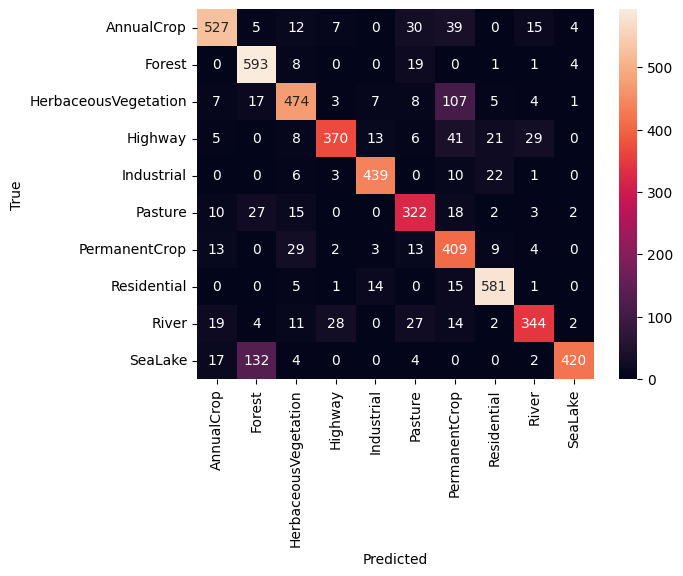

In [21]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


From the confusion matrix above, we could know the performance of the model on the set test

In [22]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Below is the example of my model's prediction. 

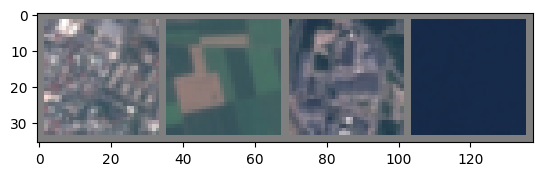

Predicted: Residential AnnualCrop Industrial SeaLake
Actual: Residential AnnualCrop Industrial SeaLake


In [23]:
# Displaying some example images with their labels
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Use next() function to get the next batch
imshow(torchvision.utils.make_grid(images))

# Assuming model prediction code is correctly handled above and stored in 'all_preds'
# Note: Ensure that 'all_preds' is filled with predictions before using it here.

# Print predicted and actual labels
# Here's how you might need to correct or adjust the prediction retrieval, just in case:
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    predicted_labels = [dataset.classes[pred] for pred in predicted]
    actual_labels = [dataset.classes[labels[j]] for j in range(len(labels))]

print('Predicted:', ' '.join(predicted_labels))
print('Actual:', ' '.join(actual_labels))
